<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_6_SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title IMPORTS 
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

In [8]:
#@title HYPERPARAMETERS 
dataset_name = "img_align_celeba" #@param ["img_align_celeba"]
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

datasets = { "img_align_celeba" : { "url" : 'https://www.dropbox.com/s/5hznryk2m0qxs2m/img_align_celeba.zip?dl=1',
                          "annotations" : "https://www.dropbox.com/s/vsxuglogmz4ezcf/list_attr_celeba.txt?dl=1",
                          "train_mode" : "train",
                          "test_mode" : "test"}           
            }

hp = Hyperparameters(
    epoch=0,
    n_epochs=200,
    batch_size=16,    
    train_split=.1,
    dataset_name=dataset_name,
    dataset_url=datasets[dataset_name]["url"],
    dataset_annotations=datasets[dataset_name]["annotations"],
    dataset_train_mode=datasets[dataset_name]["train_mode"],
    dataset_test_mode=datasets[dataset_name]["test_mode"], 
    lr=.0002,    
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    hr_size=256,
    channels=3,
    latent_dim=8,    
    sample_interval=150)

img_root_folder = 'images'
os.makedirs(img_root_folder, exist_ok=True)
image_folder = img_root_folder + "/%s" % hp.dataset_name 
print(f"Image data folders constructed {image_folder}")
os.makedirs(image_folder, exist_ok=True)

Image data folders constructed images/img_align_celeba


In [3]:
#@title DOWNLOAD IMAGES
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = hp.dataset_url
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:        
        zfile.extractall(img_root_folder)
        print(f"Downloaded & Extracted {zipurl}")

Downloaded & Extracted https://www.dropbox.com/s/5hznryk2m0qxs2m/img_align_celeba.zip?dl=1


In [126]:
#@title IMAGE DOWNLOAD HELPERS AND FORATTERS
import glob
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize(int(1.5*hr_height), Image.BICUBIC),
                transforms.CenterCrop(hr_height),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )

        self.files = sorted(glob.glob(root + "/*.*"))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [123]:
#@title IMAGE VISUALIZER HELPERS
def transpose(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def imshow(img,size=10):  
  plt.figure(figsize=(size, size))
  plt.imshow(transpose(img))
  plt.show()

def transpose(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def to_img(x):    
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg
def visualise_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

In [127]:
#@title CONFIGURE DATALOADERS

hr_shape = (hp.hr_size, hp.hr_size)

dataloader = DataLoader(
    ImageDataset(image_folder, hr_shape=hr_shape),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=hp.n_cpu,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


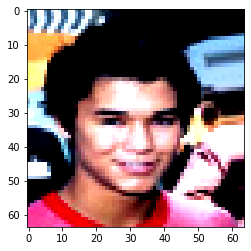

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


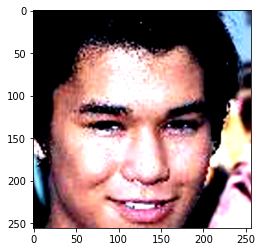

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


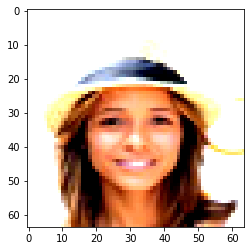

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


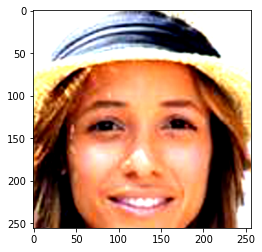

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


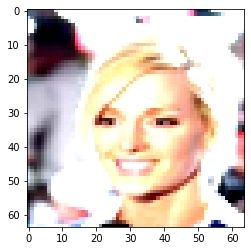

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


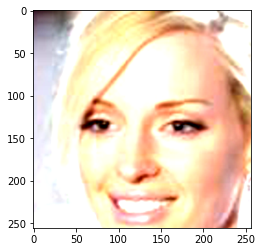

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


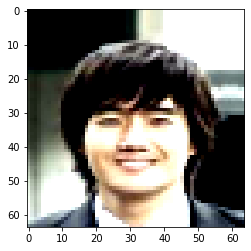

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


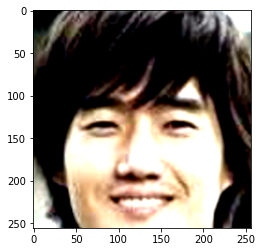

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


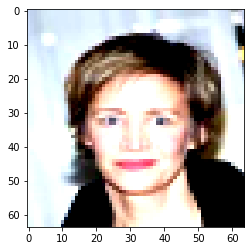

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


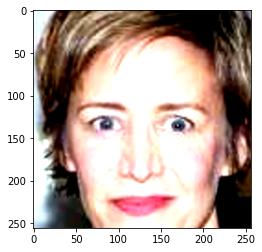

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


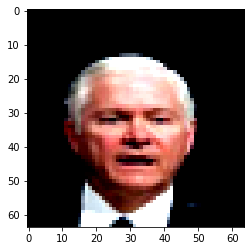

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


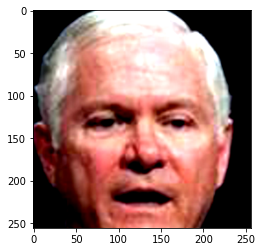

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


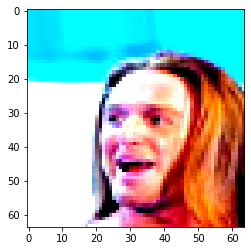

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


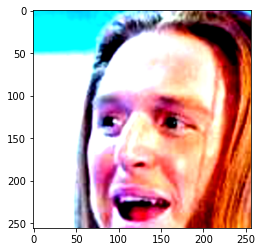

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


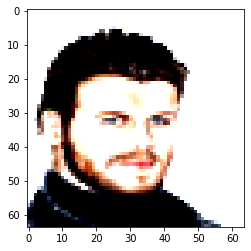

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


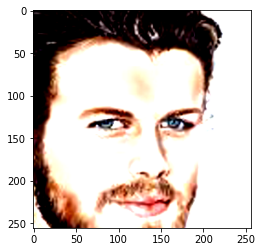

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


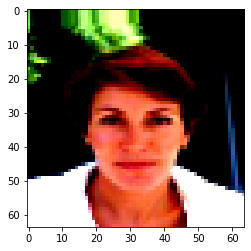

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


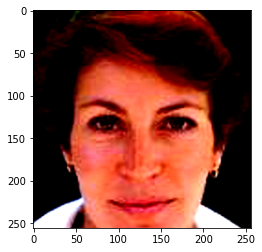

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


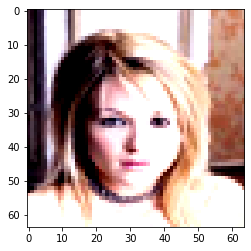

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


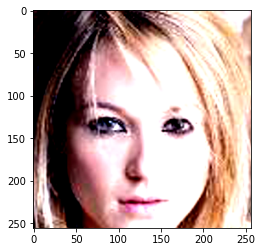

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


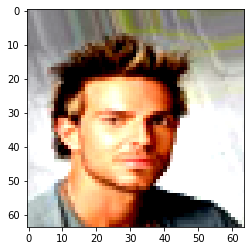

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


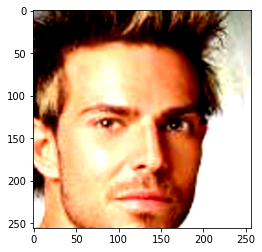

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


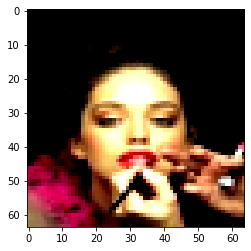

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


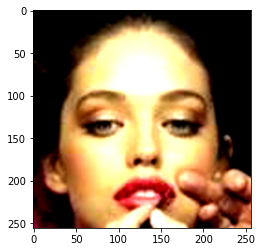

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


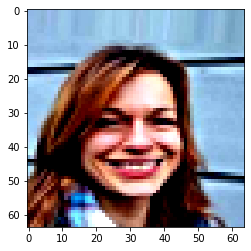

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


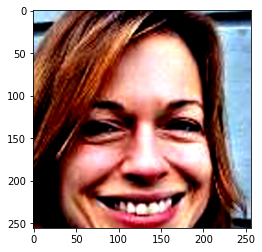

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


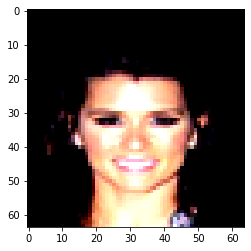

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


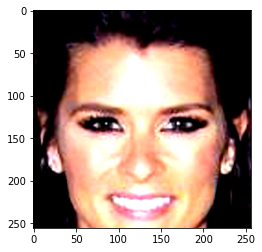

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


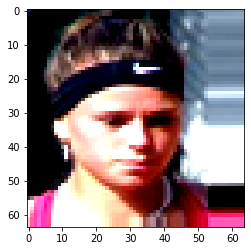

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


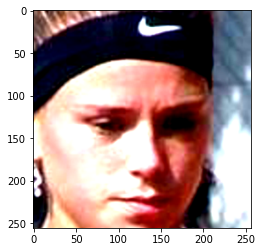

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


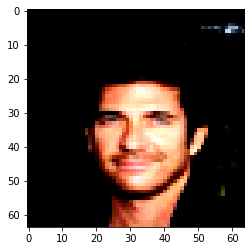

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


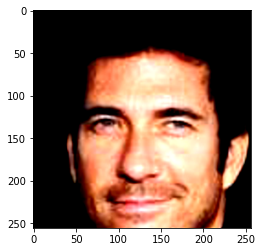

In [128]:
#@title VISUALING SAMPLE DATA { run: "auto" }
pic_size = 4 #@param {type:"integer"} {type:"slider", min:1, max:30, step:1}

dataiter = iter(dataloader)
imgs = dataiter.next()

for i in range(hp.batch_size):  
  a = make_grid(imgs["lr"][i])
  b = make_grid(imgs["hr"][i])
  imshow(a, size = pic_size)
  imshow(b, size = pic_size)
  


In [108]:
#@title GENERATOR & DISCRIMINATOR
import torch.nn.functional as F
from torchvision.models import vgg19
import math

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [129]:
#@title SETUP, LOSS and INITIALIZE MODELS 

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(hp.channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()


Using CUDA


In [130]:
#@title OPTIMIZERS
optimizer_G = torch.optim.Adam(generator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

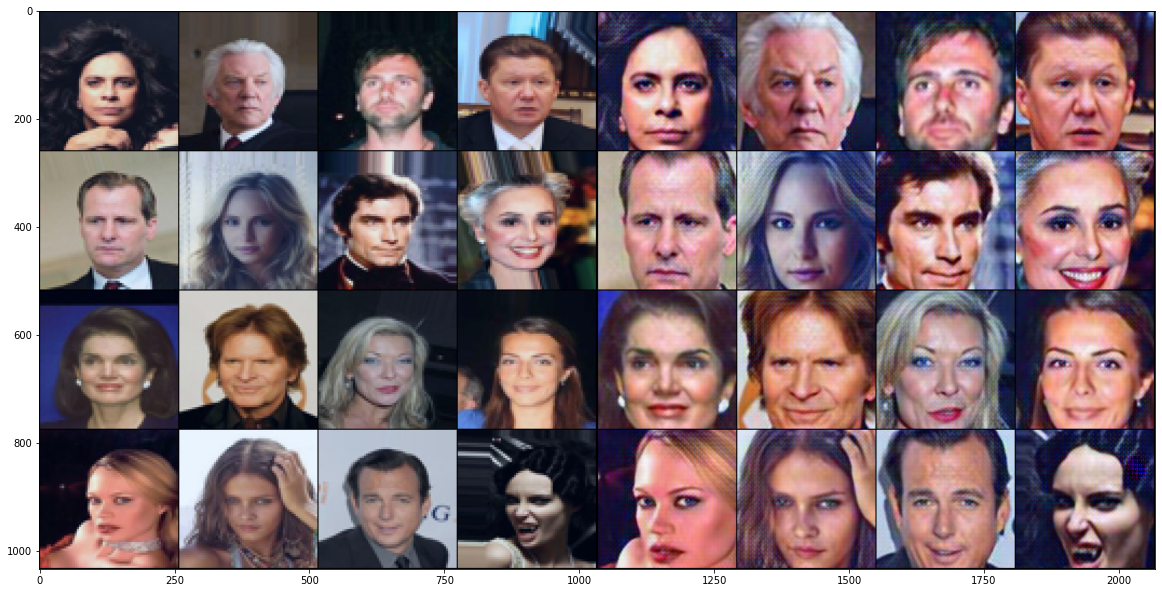

[Epoch 8/200] [Batch 4125/12663] [D loss: 0.000026] [G loss: 0.554927]

In [ ]:
#@title TRAINING
for epoch in range(hp.n_epochs):
    for i, imgs in enumerate(dataloader):

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, hp.n_epochs, i, len(dataloader), loss_D.item(), loss_G.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % hp.sample_interval == 0:
            # Save image grid with upsampled inputs and SRGAN outputs
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_hr = make_grid(gen_hr, nrow=4, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=4, normalize=True)
            img_grid = torch.cat((imgs_lr, gen_hr), -1)
            save_image(img_grid, "images/%d.png" % batches_done, normalize=False)
            clear_output()
            visualise_output("images/%d.png" % batches_done, 20,20)
        
        